# Prepocessing

In [18]:
import os

def remove_non_jpg_files(folder_path):
    """Removes all files from a folder that do not have the .jpg extension."""
    for filename in os.listdir(folder_path):
        if not filename.endswith(".jpg"):
            file_path = os.path.join(folder_path, filename)
            os.remove(file_path)


# List of folder paths to process
folder_paths = [
    '/kaggle/input/capstone-project/drive-download-20240530T171920Z-001/Healthy',
    '/kaggle/input/capstone-project/drive-download-20240530T171920Z-001/Miner',
    '/kaggle/input/capstone-project/drive-download-20240530T171920Z-001/Phoma',
    '/kaggle/input/capstone-project/drive-download-20240530T171920Z-001/Rust',
]

# Process each folder
for folder in folder_paths:
    remove_non_jpg_files(folder)

In [19]:
#cek label
from pathlib import Path
image_dir = Path('/kaggle/input/capstone-project/drive-download-20240530T171920Z-001')

filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [20]:
import pandas as pd
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(5)

,Filepath,Label
0,/kaggle/input/capstone-project/drive-download-...,Healthy
1,/kaggle/input/capstone-project/drive-download-...,Miner
2,/kaggle/input/capstone-project/drive-download-...,Phoma
3,/kaggle/input/capstone-project/drive-download-...,Miner
4,/kaggle/input/capstone-project/drive-download-...,Healthy


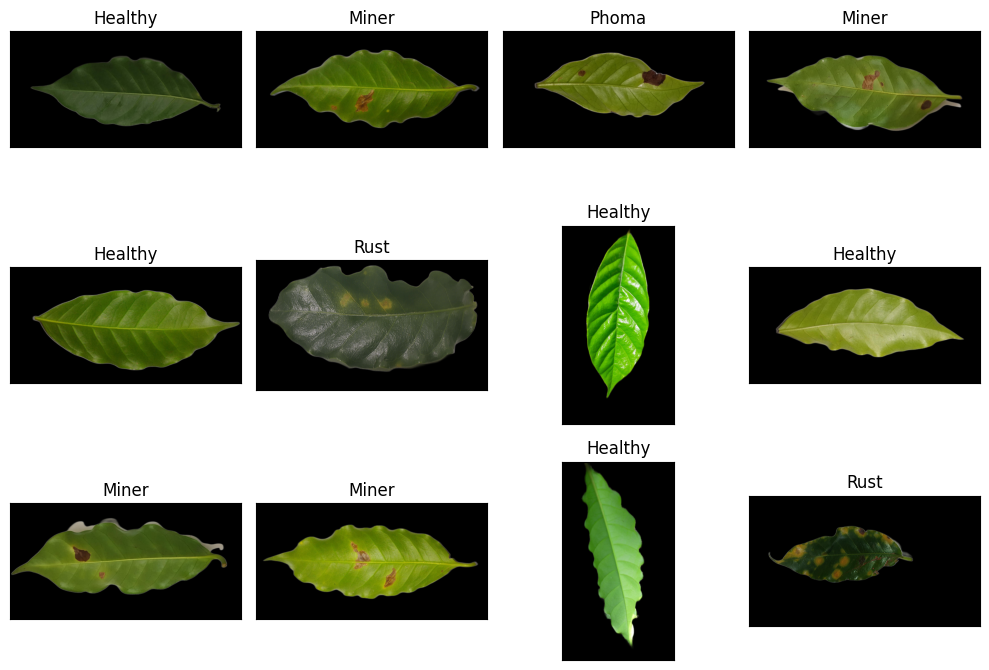

In [21]:
# Display some pictures of the dataset with their labels
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

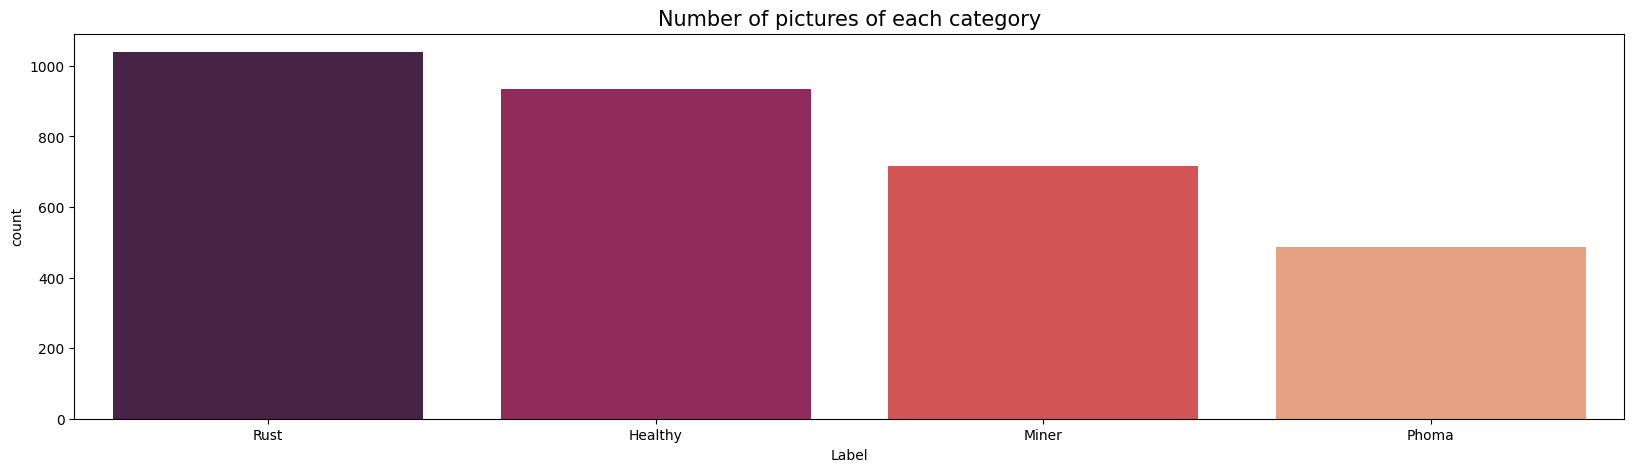

In [22]:

# Display the number of pictures of each category
import seaborn as sns
vc = image_df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [23]:
#Shuffle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# Separate in train and test data
train_df, validasi_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [24]:
import tensorflow as tf #Import tensorflow

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator( # Use tf.keras.preprocessing.image.ImageDataGenerator
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # Use tf.keras.preprocessing.image.ImageDataGenerator

train_data = train_datagen.flow_from_dataframe(dataframe=train_df,
                                          x_col='Filepath',
                                          y_col='Label',
                                         seed=0,
                                         target_size=(224,224),
                                         batch_size=32,
                                         shuffle=True,
                                         class_mode = 'categorical',
                                        subset='training',
                                         )

validasi_data = val_datagen.flow_from_dataframe(dataframe=validasi_df,
                                        x_col='Filepath',
                                        y_col='Label',
                                         seed=0,
                                         target_size=(224,224),
                                         batch_size=32,
                                         shuffle=False,
                                         class_mode = 'categorical',
                                         )

Found 2859 validated image filenames belonging to 4 classes.
Found 318 validated image filenames belonging to 4 classes.


# Built Inception

In [25]:
# Download the pre-trained weights for ResNet101V2. No top means it excludes the fully connected layer.
!wget --no-check-certificate \
    https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet101v2_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/resnet101v2_weights_tf_dim_ordering_tf_kernels_notop.h5

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-10-10 11:09:00--  https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet101v2_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.207, 74.125.203.207, 142.251.8.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 171317808 (163M) [application/octet-stream]
Saving to: '/tmp/resnet101v2_weights_tf_dim_ordering_tf_kernels_notop.h5'

/tmp/resnet101v2_we 100%[===================>] 163.38M  27.0MB/s    in 7.3s    

2024-10-10 11:09:07 (22.3 MB/s) - '/tmp/resnet101v2_weights_tf_dim_ordering_tf_kernels_notop.h5' saved [171317808/171317808]



In [26]:
from keras import Model, Input
input_shape = (224,224,3)
model_input = Input(shape=input_shape)

In [27]:
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/resnet101v2_weights_tf_dim_ordering_tf_kernels_notop.h5'


# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = ResNet101V2(input_shape = (224, 224, 3),
                                include_top = False,
                                input_tensor=model_input,
                                weights = "imagenet")

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [28]:
pre_trained_model.summary()

Model: "resnet101v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 42,626,560 (162.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 42,626,560 (162.61 MB)

In [29]:
# Choose `conv5_block1_1_conv` as the last layer of your base model
last_layer = pre_trained_model.get_layer('conv4_block6_out')
print('last layer output shape: ', last_layer.output.shape) # Use output.shape instead of output_shape
last_output = last_layer.output

last layer output shape:  (None, 14, 14, 1024)


In [30]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = GlobalAveragePooling2D()(last_output)
x = layers.Flatten()(x)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (4, activation='softmax')(x)

# Append the dense network to the base model
resnet101v2 = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
resnet101v2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 9,100,292 (34.71 MB)

 Trainable params: 526,852 (2.01 MB)

 Non-trainable params: 8,573,440 (32.71 MB)

In [31]:
import tensorflow as tf
from keras.callbacks import EarlyStopping
class EarlyStoppingAtMaxAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('val_accuracy')>=0.99):
            print("\nAccuracy is high so cancelling training!")
            self.model.stop_training = True
callbacks = EarlyStoppingAtMaxAccuracy()

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Tentukan path penyimpanan model
checkpoint_path = '/content/drive/MyDrive/model/resnet101v2.keras'

# Buat callback ModelCheckpoint
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_loss',  # Metrik yang akan dipantau
                                      save_best_only=True,  # Hanya menyimpan model terbaik
                                      save_weights_only=False,  # Menyimpan seluruh model
                                      mode='min',  # Mode pemantauan (misalnya, 'min', 'max', atau 'auto')
                                      verbose=1)  # Menampilkan pesan saat menyimpan

In [33]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, RMSprop

# 1. SGD with Momentum
sgd_optimizer = SGD(learning_rate=0.0001, momentum=0.9)
rmsprop_optimizer = RMSprop(learning_rate=0.0001)

# Function to save model and train with different optimizers
def train_with_optimizer(resnet101v2, optimizer, train_data, validasi_data, optimizer_name):
    # Compile the model
    resnet101v2.compile(optimizer=optimizer,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

    # Train the model
    history = resnet101v2.fit(
        train_data,
        validation_data=validasi_data,
        epochs=30,
        batch_size=32,
        callbacks=([callbacks],[checkpoint_callback]),
        verbose=1
    )
    
    return history

# Example usage for training with SGD and RMSprop
optimizers = {
    'SGD': sgd_optimizer,
    'RMSprop': rmsprop_optimizer,
}

results = {}
for name, opt in optimizers.items():
    print(f"Training with {name}...")
    history = train_with_optimizer(resnet101v2, opt, train_data, validasi_data, name)
    results[name] = history.history

Training with SGD...
Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.2739 - loss: 1.3920
Epoch 1: val_loss improved from inf to 1.34843, saving model to /content/drive/MyDrive/model/resnet101v2.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 87s 805ms/step - accuracy: 0.2743 - loss: 1.3919 - val_accuracy: 0.3899 - val_loss: 1.3484
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.3288 - loss: 1.3579
Epoch 2: val_loss improved from 1.34843 to 1.33692, saving model to /content/drive/MyDrive/model/resnet101v2.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 72s 751ms/step - accuracy: 0.3288 - loss: 1.3579 - val_accuracy: 0.3239 - val_loss: 1.3369
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.3352 - loss: 1.3548
Epoch 3: val_loss improved from 1.33692 to 1.32287, saving model to /content/drive/MyDrive/model/resnet101v2.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 74s 767ms/step - accuracy: 0.3351 - loss: 1.3548 - val_accuracy: 0.3711 - val_loss: 1.3229
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accu

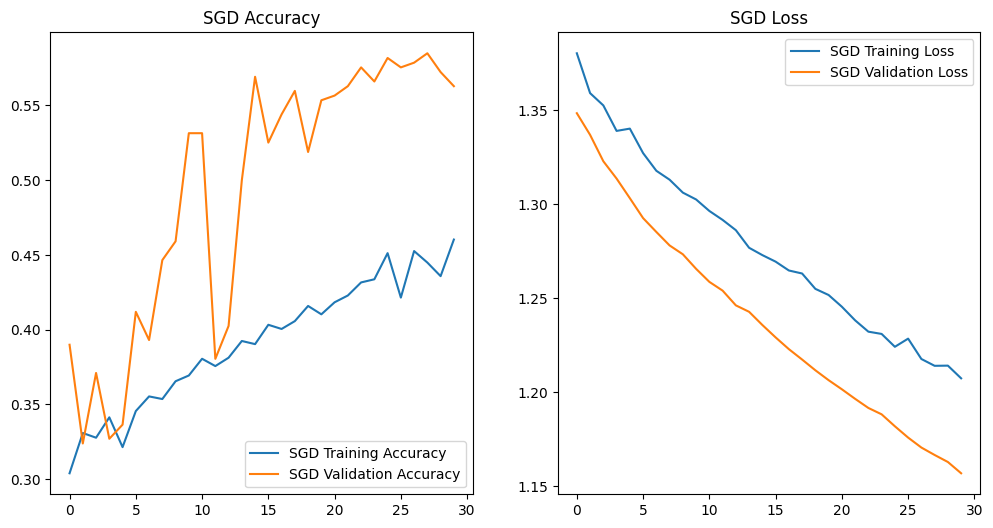

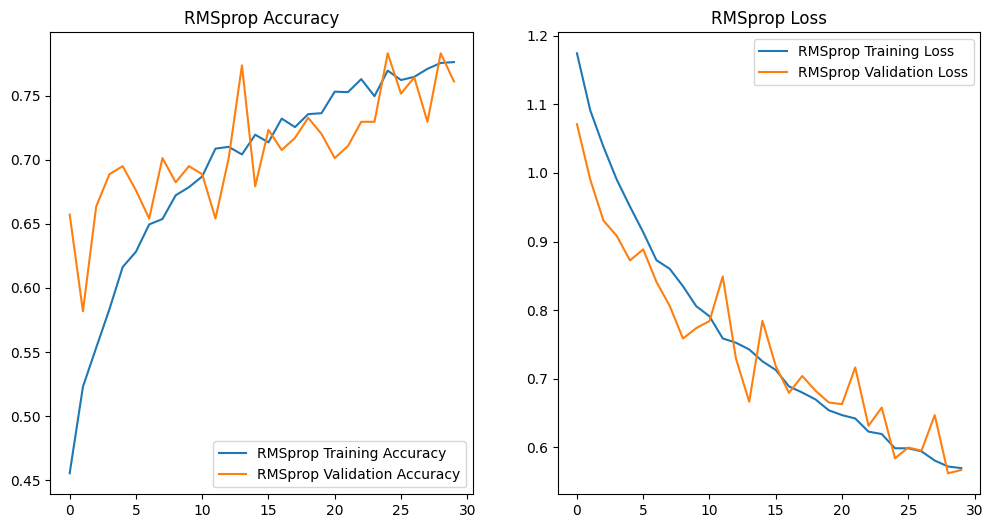

In [34]:
# Plotting function to visualize training results
def plot_training_results(results):
    for optimizer_name, history in results.items():
        acc = history['accuracy']
        val_acc = history['val_accuracy']
        loss = history['loss']
        val_loss = history['val_loss']
        
        epochs_range = range(len(acc))

        plt.figure(figsize=(12, 6))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label=f'{optimizer_name} Training Accuracy')
        plt.plot(epochs_range, val_acc, label=f'{optimizer_name} Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title(f'{optimizer_name} Accuracy')

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label=f'{optimizer_name} Training Loss')
        plt.plot(epochs_range, val_loss, label=f'{optimizer_name} Validation Loss')
        plt.legend(loc='upper right')
        plt.title(f'{optimizer_name} Loss')

        plt.show()

# Call the function to plot results
plot_training_results(results)

10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 647ms/step


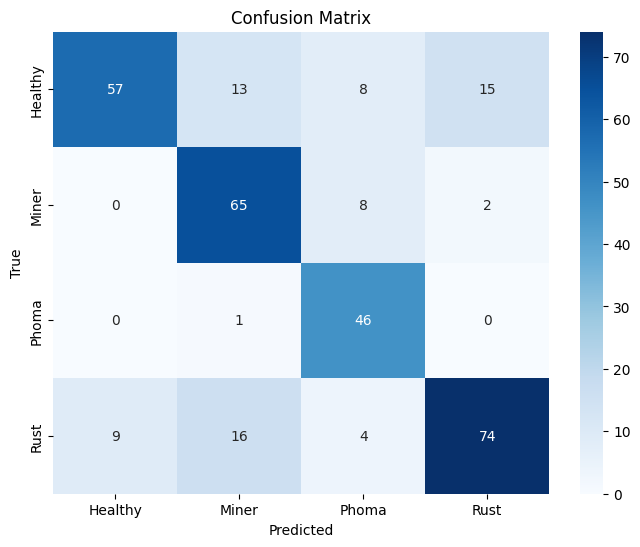

              precision    recall  f1-score   support

     Healthy       0.86      0.61      0.72        93
       Miner       0.68      0.87      0.76        75
       Phoma       0.70      0.98      0.81        47
        Rust       0.81      0.72      0.76       103

    accuracy                           0.76       318
   macro avg       0.76      0.79      0.76       318
weighted avg       0.78      0.76      0.76       318



In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Function to evaluate model and generate confusion matrix
def evaluate_model_and_plot_confusion_matrix(resnet101v2, validasi_data, class_names):
    # Predict on the validation data
    y_pred = resnet101v2.predict(validasi_data)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted classes
    y_true = validasi_data.classes  # True classes

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report for more metrics (precision, recall, F1-score)
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Example usage after training
class_names = ['Healthy', 'Miner', 'Phoma', 'Rust']  # Replace with actual class names
evaluate_model_and_plot_confusion_matrix(resnet101v2, validasi_data, class_names)

In [39]:

# # Set the training parameters
# callbacks= myCallback()
resnet101v2.compile(optimizer = Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [50]:
history_resnet101v2 = resnet101v2.fit(
                  train_data,
                  batch_size=32,
                  validation_data=validasi_data,
                  epochs=30, callbacks=([callbacks],[checkpoint_callback]))

Epoch 1/30

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 937ms/step - accuracy: 0.9714 - loss: 0.0842

Epoch 1: val_loss did not improve from 0.04299

80/80 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9714 - loss: 0.0841 - val_accuracy: 0.8994 - val_loss: 0.3794

Epoch 2/30

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 0.9796 - loss: 0.0605

Epoch 2: val_loss did not improve from 0.04299

80/80 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9796 - loss: 0.0605 - val_accuracy: 0.9513 - val_loss: 0.1724

Epoch 3/30

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.9843 - loss: 0.0548

Epoch 3: val_loss did not improve from 0.04299

80/80 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9843 - loss: 0.0546 - val_accuracy: 0.9638 - val_loss: 0.1040

Epoch 4/30

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 937ms/step - accuracy: 0.9881 - loss: 0.0507

Epoch 4: val_loss did not improve from 0.04299

80/80 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9881 - loss: 0.0507 - val_accuracy: 0.9481 - val_loss: 

# Saved Model to .h5

In [51]:
MODEL_BASE_PATH = "/content/drive/MyDrive/model/"
PROJECT_NAME = "H5"
SAVE_MODEL_NAME = "resnet30epoch.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

print('Saving Model At {}...'.format(save_model_path))
resnet101v2.save(save_model_path,include_optimizer=False)

Saving Model At /content/drive/MyDrive/model/H5/resnet30epoch.h5...


In [52]:
resnet101v2.evaluate(validasi_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 600ms/step - accuracy: 0.9943 - loss: 0.0346


[0.04787979647517204, 0.9905660152435303]

# Plotting Accuration After Training and Test Model

In [53]:
#plotting
import matplotlib.pyplot as plt
def display_training_curves(training, validation, title, subplot):

    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(6,8), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

<ipython-input-53-640e4c0dc1bc>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.

  ax = plt.subplot(subplot)


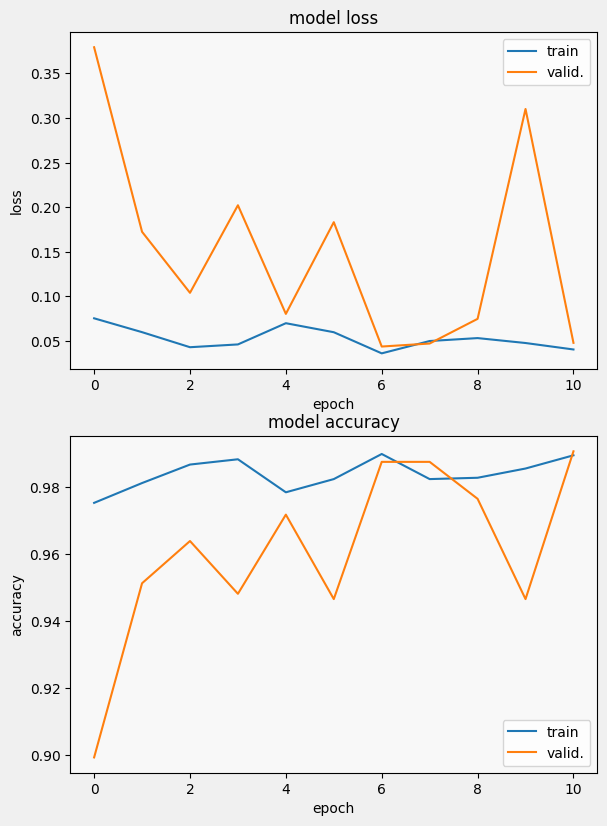

In [54]:
#display
display_training_curves(
    history_resnet101v2.history['loss'],
    history_resnet101v2.history['val_loss'],
    'loss', 211)
display_training_curves(
    history_resnet101v2.history['accuracy'],
    history_resnet101v2.history['val_accuracy'],
    'accuracy', 212)

In [56]:
# Predict the label of the test_images
import numpy as np
pred = resnet101v2.predict(validasi_data)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:4]}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 745ms/step

The first 5 predictions: ['Rust', 'Miner', 'Rust', 'Rust']


In [57]:
#classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_test = list(validasi_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support



     Healthy       0.98      0.99      0.98       162

       Miner       0.99      1.00      1.00       158

       Phoma       1.00      1.00      1.00       101

        Rust       1.00      0.98      0.99       215



    accuracy                           0.99       636

   macro avg       0.99      0.99      0.99       636

weighted avg       0.99      0.99      0.99       636




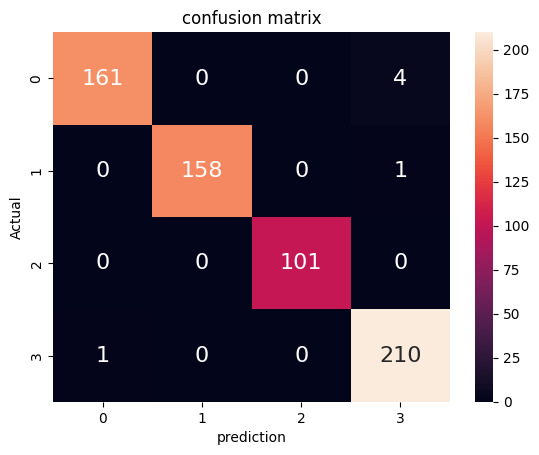

In [58]:
import seaborn as sns
import pandas as pd
cm  = confusion_matrix(pred,y_test)
df_cm = pd.DataFrame(cm, index = [i for i in range(4)],
                  columns = [i for i in range(4)])
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d')
plt.title('confusion matrix')
plt.xlabel('prediction')
plt.ylabel('Actual');

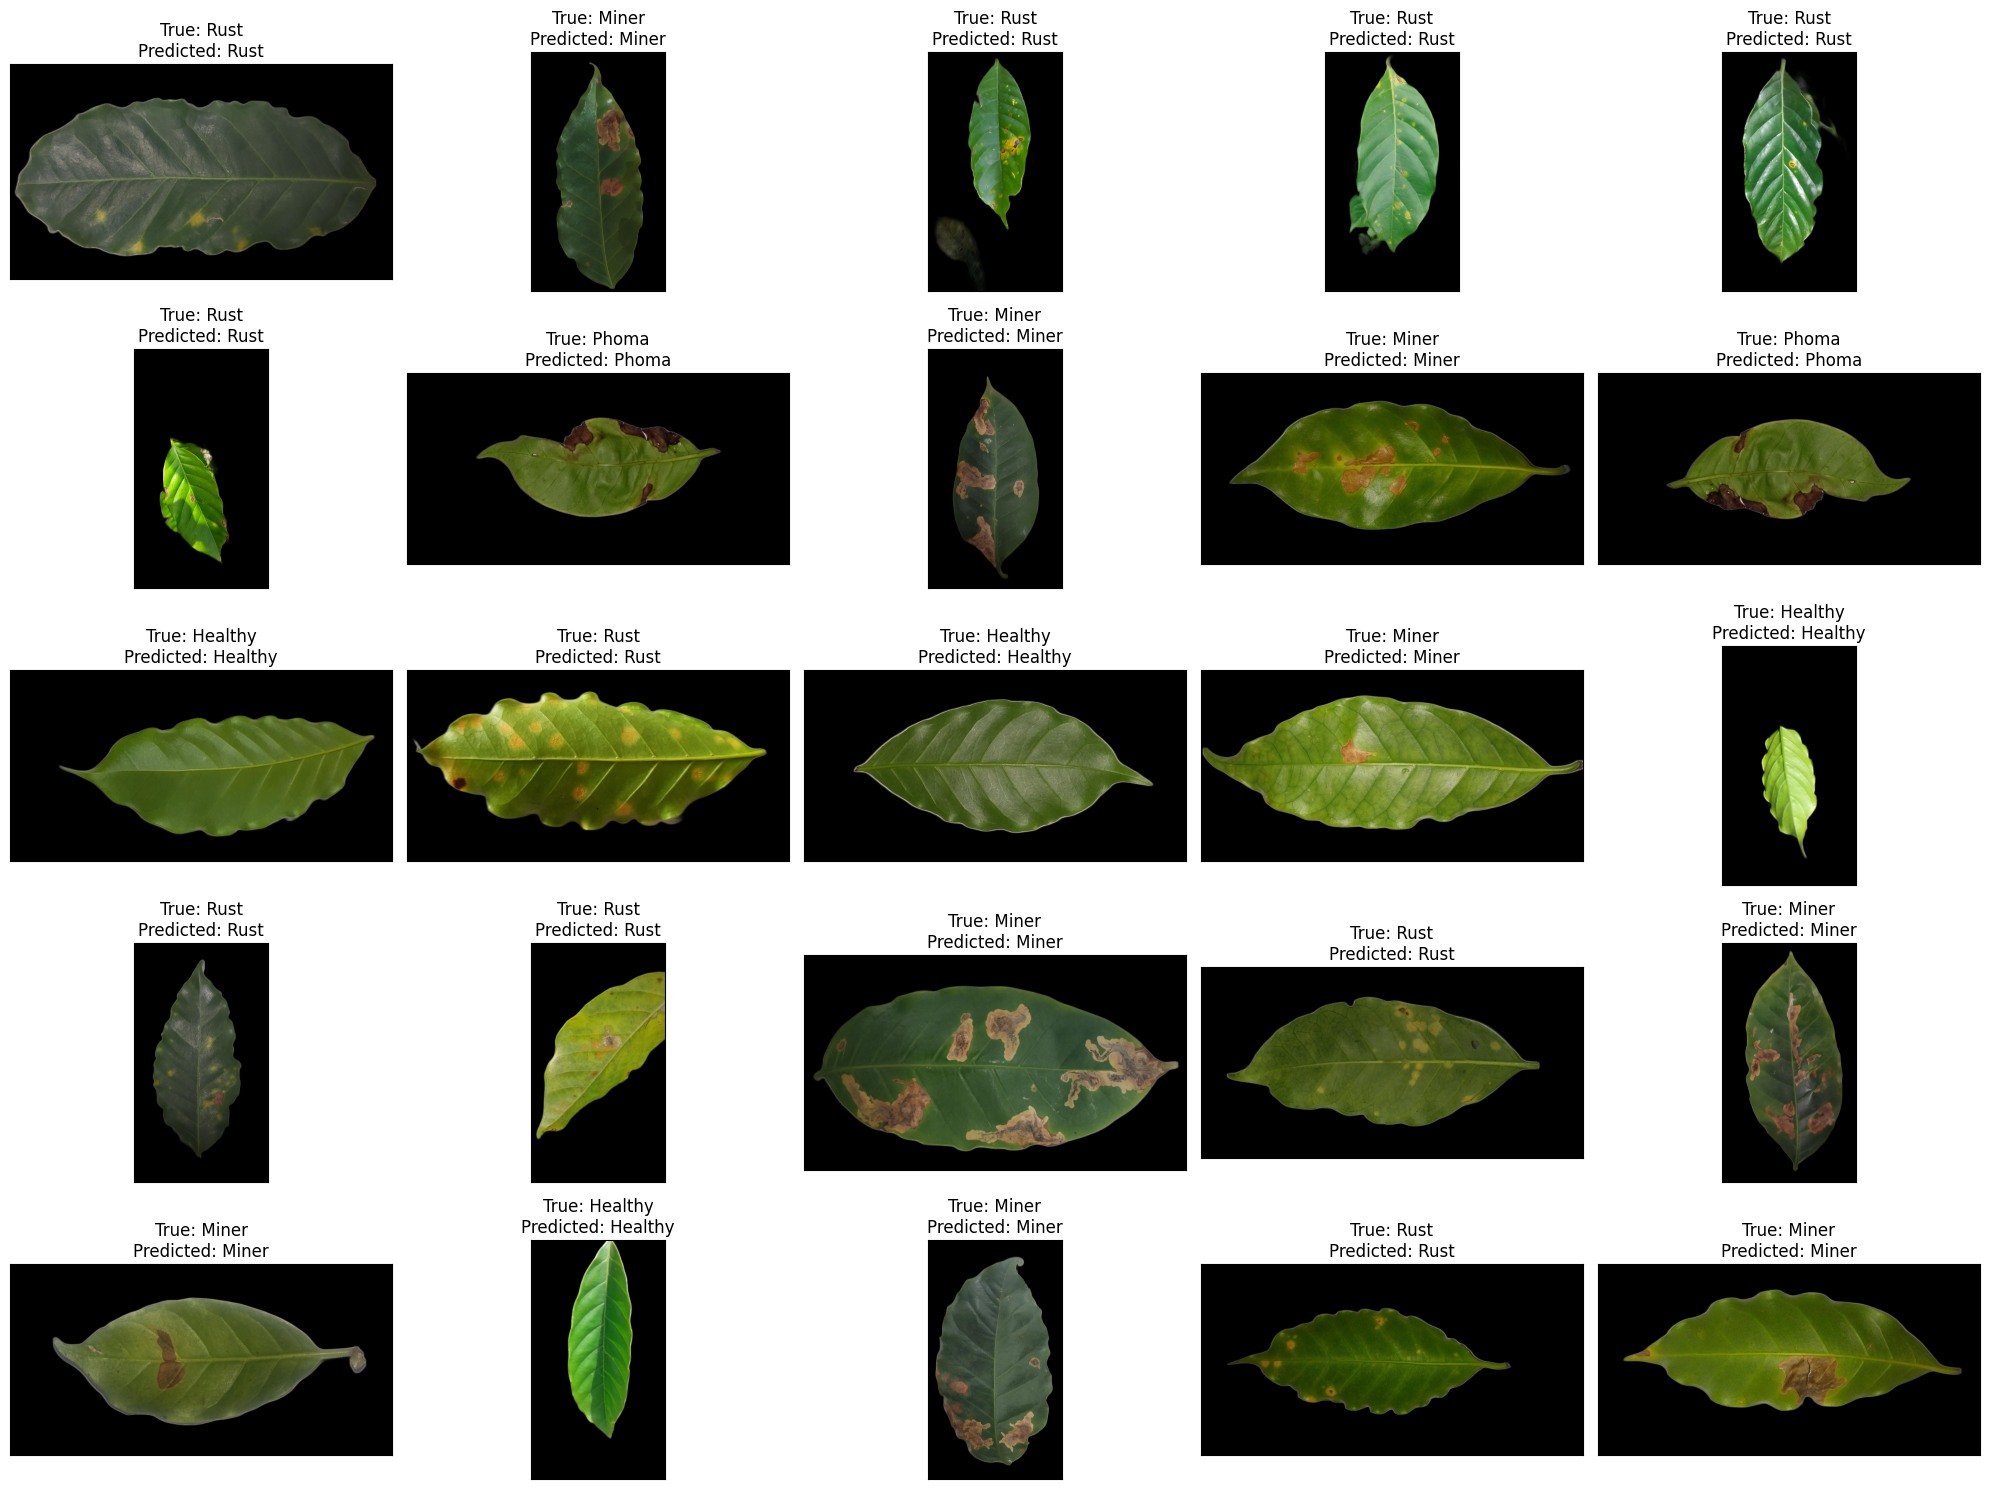

In [59]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(validasi_df.Filepath.iloc[i]))
    ax.set_title(f"True: {validasi_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()